# DESI Observing Statistics

In [1]:
%pylab inline
import pandas as pd
import numpy as np
from collections import OrderedDict
import matplotlib.pyplot as plt

Populating the interactive namespace from numpy and matplotlib


In [2]:
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 12

## Observing Data

The file 'obs_may21.csv' includes all observing data since before the shutdown in the same format except for observing post-shutdown in 2020. Those statistics are captured in the dictionary 'pre_jan'

In [3]:
obs_df = pd.read_csv('obs_may21.csv')
obs_df['Date'] = pd.to_datetime(obs_df['Date'], format='%d-%b-%y')

In [4]:
# All observations through end of June 2021. Note: This includes observations planned but not completed
obs_df_total = obs_df #obs_df[obs_df.Date < '2021-06-01']
for p in ['LO_1', 'LO_2', 'OS_1', 'OS_2', 'DQS_1', 'DQS_2', 'Other']:
    obs_df_total[p] = obs_df_total[p].astype('str').str.strip()

In [5]:
# All observations in 2021 including shifts signed up for in June but not yet completed
obs_df_2021 = obs_df_total[obs_df_total.Date > '2020-12-31']

In [6]:
pre_jan = {'Ann Elliot': 13,
          'Aaron Meisner': 4,
          'James Lasker': 5,
          'Michael Schubnell': 17,
          'Martin Landriau': 7.5,
          'Satya Gontcho A Gontcho': 6.5,
          'Luke Tyas': 5,
          'Elizabeth Buckley-Geer': 1.5,
          'Arjun Dey': 0.5,
          'Connie Rockosi': 0.5,
          'Segev BenZvi': 0.5}

In [7]:
LO_names = ['Ann Elliott','Satya Gontcho A Gontcho','Martin Landriau','James Lasker','Michael Schubnell','Claire Poppett',
           'Elizabeth Buckley-Geer','Luke Tyas','Parker Fagrelius']

In [39]:
#Has institution name for each observer
trac = pd.read_csv('TracActivity.csv')
institutions = pd.read_csv('inst.csv')

## Determine Number of shifts per Observer

In [40]:
all_obs = [list(obs_df[col]) for col in ['LO_1', 'LO_2', 'OS_1', 'OS_2', 'DQS_1', 'DQS_2', 'Other']]
all_obs = np.unique(np.hstack(all_obs))    

In [41]:
def obs_stats(df,all_time):
    OBS = []
    for obs in all_obs:
        total = 0
        if all_time == True:
            try:
                total += pre_jan[obs]
            except:
                pass
        for i,row in df.iterrows():
            if row['Other'] == obs:
                total += 1
            else:
                for role in ['LO','OS','DQS']:
                    if row['{}_1'.format(role)] == obs:
                        if str(row['{}_2'.format(role)]) in ['',' ','nan','None']:
                            total += 1
                        else:
                            total += 0.5
                    if row['{}_2'.format(role)] == obs:
                        total += 0.5

        #get institution
        try:
            i = list(trac[trac.name==obs.strip()].institute)[0]
            inst = institutions[institutions.inst == i].short.values[0]
        except:
            print("Dont have an institution for this person: ",obs)
            if str(obs) in ['-','',' ','None','nan']:
                inst = None
            else:
                inst = 'Unknown'

        OBS.append([obs, inst, total])           
    return OBS

In [42]:
OBS_ = obs_stats(obs_df_total,True)
OBS_ = pd.DataFrame(OBS_,columns = ['name','Institution','Total'])

Dont have an institution for this person:  -
Dont have an institution for this person:  Adam Hawken
Dont have an institution for this person:  Martina Fagioli
Dont have an institution for this person:  None
Dont have an institution for this person:  Zhou Xu
Dont have an institution for this person:  nan


In [43]:
OBS_21 = obs_stats(obs_df_2021,True)
OBS_21 = pd.DataFrame(OBS_21,columns = ['name','Institution','Total'])

Dont have an institution for this person:  -
Dont have an institution for this person:  Adam Hawken
Dont have an institution for this person:  Martina Fagioli
Dont have an institution for this person:  None
Dont have an institution for this person:  Zhou Xu
Dont have an institution for this person:  nan


## Run Statistics and Plot

In [44]:
def split_names(df):
    # Splits names into First and last for prettier plotting
    split_names = [name.split(' ') for name in list(df.name)]
    df['last_name'] = [n[-1] for n in split_names]
    df['first_name'] = [' '.join(n[0:-1]) for n in split_names]

    print_name = []
    for idx, row in df.iterrows():
        print_name.append(', '.join([row['last_name'], row['first_name']]))
    df['print_name'] = print_name
    df.sort_values('print_name',inplace=True)
    return df

In [45]:
# Split into LO and Non_LO lists so that we don't skew the statistics
df_ = split_names(OBS_)
LO_df = df_[df_.name.isin(LO_names)]
NLO_df = df_[~df_.name.isin(LO_names)]
NLO_df = NLO_df[~NLO_df.name.isin(['-','None','nan'])]

In [46]:
df_21 = split_names(OBS_21)
LO_df_21 = df_21[df_21.name.isin(LO_names)]
NLO_df_21 = df_21[~df_21.name.isin(LO_names)]
NLO_df_21 = NLO_df_21[~NLO_df_21.name.isin(['-','None','nan'])]

In [47]:
LO_df_21 = LO_df_21.rename(columns={"Total": '2021A'})
LO_df_21['Total'] = LO_df['Total']

In [48]:
LO_df_21[['name','Institution','2021A','Total']]

,name,Institution,2021A,Total
38,Elizabeth Buckley-Geer,Fermilab,9.0,20.0
13,Ann Elliott,OSU,20.5,34.5
85,Parker Fagrelius,NOIRLab,2.5,19.5
95,Satya Gontcho A Gontcho,LBNL,27.5,53.5
73,Martin Landriau,LBNL,78.0,103.0
51,James Lasker,SMU,30.5,42.5
26,Claire Poppett,LBNL,9.0,29.0
77,Michael Schubnell,Michigan,33.0,45.0
68,Luke Tyas,Durham,15.5,40.5


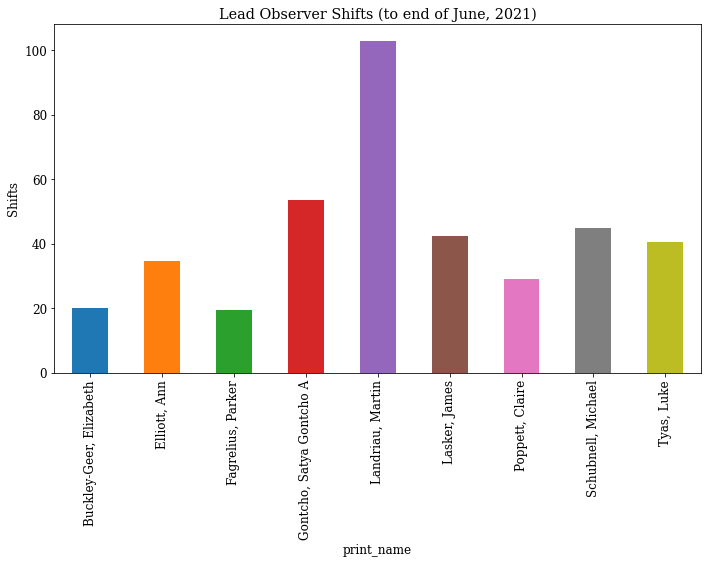

In [49]:
LO_df.plot.bar(x='print_name',y='Total',color=plt.cm.tab10(np.arange(len(LO_df))),
                legend=None,figsize=(10,8))
plt.ylabel("Shifts")
plt.title("Lead Observer Shifts (to end of June, 2021)")
plt.tight_layout()
plt.savefig('lo_stats_jun2021.png')

47


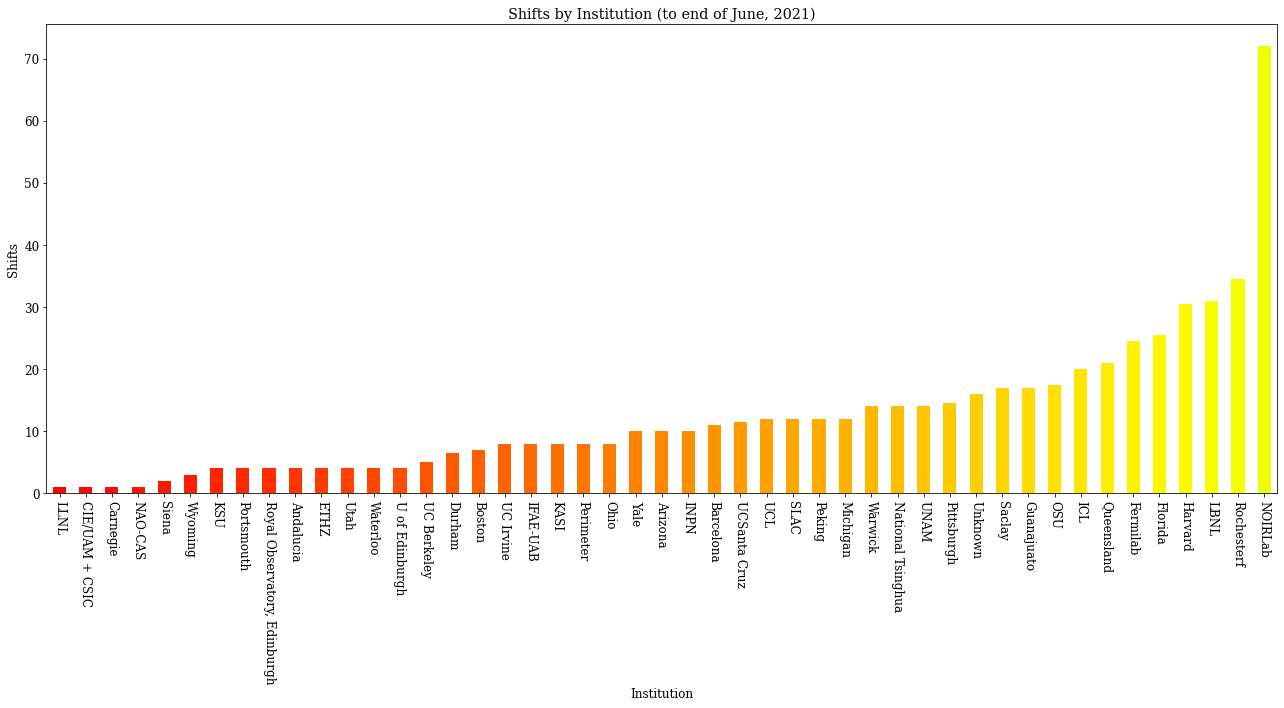

In [62]:
fig, ax = plt.subplots(1, figsize=(18,10))
NLO_df.groupby('Institution').sum().Total.sort_values().plot.bar(x='Institution',y='Total',legend=None,color=plt.cm.hsv(np.arange(len(NLO_df))),rot=270,ax=ax)
                   
# ax.patch.set_alpha(0.1)
# ax.spines['bottom'].set_color('white')
# ax.xaxis.label.set_color('white')
# ax.yaxis.label.set_color('white')
# ax.tick_params(axis='x', colors='white')
# ax.tick_params(axis='y', colors='white')
                                                 
ax.set_ylabel("Shifts")
ax.set_title("Shifts by Institution (to end of June, 2021)")
fig.tight_layout()
plt.savefig('inst_shifts.png')
print(len(np.unique(NLO_df.Institution)))

101


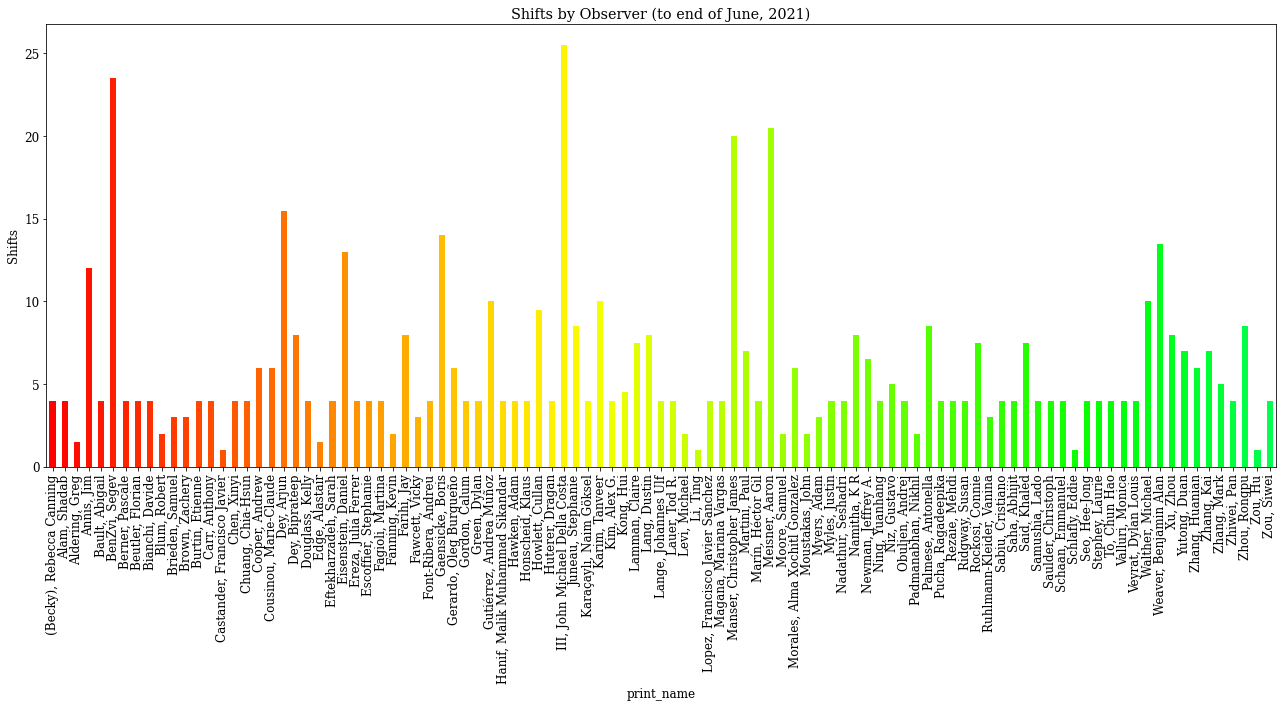

In [61]:
nlo_obs = NLO_df[NLO_df.Total > 0]
fig, ax = plt.subplots(1, figsize=(18,10))
nlo_obs.plot.bar(x='print_name',y='Total',color=plt.cm.hsv(np.arange(len(NLO_df))),legend=None,ax=ax)
#ax.patch.set_alpha(0.1)
#ax.spines['bottom'].set_color('white')
#ax.xaxis.label.set_color('white')
#ax.yaxis.label.set_color('white')
#ax.tick_params(axis='x', colors='white')
#ax.tick_params(axis='y', colors='white')

ax.set_ylabel("Shifts")
ax.set_title("Shifts by Observer (to end of June, 2021)")
fig.tight_layout()
print(len(np.unique(nlo_obs.name)))
plt.savefig('obs_shifts.png')

In [53]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(NLO_df[['print_name','Institution','Total']].sort_values(['print_name']))

                          print_name                   Institution  Total
89          (Becky), Rebecca Canning                    Portsmouth    4.0
98                      Alam, Shadab  Royal Observatory, Edinburgh    4.0
44                    Aldering, Greg                          LBNL    1.5
54                        Annis, Jim                      Fermilab   12.0
3                     Bault, Abigail                     UC Irvine    4.0
96                     BenZvi, Segev                    Rochesterf   23.5
86                   Berner, Pascale                          ETHZ    4.0
41                  Beutler, Florian                U of Edinburgh    4.0
31                   Bianchi, Davide                     Barcelona    4.0
90                      Blum, Robert                       NOIRLab    2.0
92                   Brieden, Samuel                     Barcelona    3.0
110                   Brown, Zachery                    Rochesterf    3.0
40                   Burtin, Etienne  

In [59]:
pd.set_option('display.max_rows', None)
NLO_df[['print_name','Institution','Total']].sort_values(['print_name']).reset_index(drop=True)

,print_name,Institution,Total
0,"(Becky), Rebecca Canning",Portsmouth,4.0
1,"Alam, Shadab","Royal Observatory, Edinburgh",4.0
2,"Aldering, Greg",LBNL,1.5
3,"Annis, Jim",Fermilab,12.0
4,"Bault, Abigail",UC Irvine,4.0
5,"BenZvi, Segev",Rochesterf,23.5
6,"Berner, Pascale",ETHZ,4.0
7,"Beutler, Florian",U of Edinburgh,4.0
8,"Bianchi, Davide",Barcelona,4.0
9,"Blum, Robert",NOIRLab,2.0


In [54]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(NLO_df[['print_name','Institution','Total']].sort_values(['Total']))

                          print_name                   Institution  Total
47                           Zou, Hu                       NAO-CAS    1.0
104                         Li, Ting                      Carnegie    1.0
42       Castander, Francisco Javier                CIE/UAM + CSIC    1.0
37                   Schlafly, Eddie                          LLNL    1.0
44                    Aldering, Greg                          LBNL    1.5
6                     Edge, Alastair                        Durham    1.5
90                      Blum, Robert                       NOIRLab    2.0
57                   Moustakas, John                         Siena    2.0
93                     Moore, Samuel                        Durham    2.0
81               Padmanabhan, Nikhil                          Yale    2.0
63                    Fanning, Kevin                           OSU    2.0
76                     Levi, Michael                          LBNL    2.0
110                   Brown, Zachery  

In [27]:
NLO_df[NLO_df.Institution == 'Unknown']

,name,Institution,Total,last_name,first_name,print_name
83,Martina Fagioli,Unknown,4.0,Fagioli,Martina,"Fagioli, Martina"
4,Adam Hawken,Unknown,4.0,Hawken,Adam,"Hawken, Adam"
121,Zhou Xu,Unknown,8.0,Xu,Zhou,"Xu, Zhou"


In [28]:
no_obs = []
for i, row in institutions.iterrows():
    if row['inst'] in list(NLO_df.Institution):
        pass
    elif row['short'] in list(NLO_df.Institution):
        pass
    else:
        no_obs.append(row['short'])

In [29]:
no_obs

['LAM',
 'Institut Pytheas',
 'Argonne',
 'ANU',
 'Barcelona-CIEMT',
 'IEEC/CSIC',
 'UAM',
 'Brookhaven',
 'BAO',
 'Tsinghua',
 'CalState East Bay',
 'CMU',
 'Centrum Fizyki Teoretycznej',
 'Saint John’s University',
 'Cornell',
 'Flatiron',
 'Canarias',
 'Hamilton',
 'Kavli',
 'KIAS',
 'LPNHE',
 'LIneA',
 'MPI-EP',
 'CIEAIPN',
 'ININ',
 'NYU',
 nan,
 'Princeton',
 'Purple Mountain',
 'Queen Mary',
 'Seoul',
 'Shangai Jia Tong',
 'Sichuan',
 'SMU',
 'STSI',
 'Sun Yat-Sen',
 'Swinburne',
 'Cambridge',
 'Saint Andrews',
 'ECCI',
 'Andes',
 'Oslo',
 'Maryland',
 'Oxford',
 'UPenn',
 'USF',
 'U of Texas, Dallas',
 'Toronto',
 'Washington',
 'Bonn',
 'Heidelberg',
 'Zurich',
 'Paris Sud',
 'Geneve',
 'Winlight',
 'Yonsei',
 'Yunnan',
 'EPFL']